<a href="https://colab.research.google.com/github/MatheusHenriqueDaSilva/data_science/blob/main/titanic_regressao_logistica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Aplicação do algoritmo de **LogisticRegression** para predizer se a pessoa irá sobreviver ao acidente ocorrido no TITANIC

Etapas:
1.   Data prep
2.   Normalização dos dos valores contínuos
3.   one-hot encoding e Label Encoding nas variáveis categóricas
4.   treinamento e otimização de hiperparâmetros


Lembrando que no caso desse algoritmo, não é necess




In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
DATA = pd.read_csv('/content/train.csv')
DATA.describe()


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [3]:
lista_spec = ['PassengerId', 'Survived','Ticket','Name']
target = DATA['Survived']
DATA.drop(lista_spec,axis=1,inplace=True)


In [4]:
def generate_metadata(dataframe):

    metadata2 = pd.DataFrame({
        'nome_variavel': dataframe.columns,
        'tipo': dataframe.dtypes,
        'qt_nulos': dataframe.isnull().sum(),
        'percent_nulos': round((dataframe.isnull().sum() / len(dataframe))* 100,2),
        'cardinalidade': dataframe.nunique(),
    })
    metadata2=metadata2.sort_values(by='tipo')
    metadata2 = metadata2.reset_index(drop=True)

    return metadata2

metadados = generate_metadata(DATA)
metadados

,nome_variavel,tipo,qt_nulos,percent_nulos,cardinalidade
0,Pclass,int64,0,0.00,3
1,SibSp,int64,0,0.00,7
2,Parch,int64,0,0.00,7
3,Age,float64,177,19.87,88
4,Fare,float64,0,0.00,248
5,Sex,object,0,0.00,2
6,Cabin,object,687,77.10,147
7,Embarked,object,2,0.22,3


In [5]:
# Variáveis numéricas
# Filtrando o DataFrame
missing_cutoff = 70
df_numericas_drop_nulos = metadados[(metadados['percent_nulos'] >= missing_cutoff)]
lista_drop_nulos_numericas = list(df_numericas_drop_nulos.nome_variavel.values)
lista_drop_nulos_numericas

['Cabin']

In [6]:
# retirando lista de variáveis com alto percentual de nulos
data_prep = DATA.drop(axis=1,columns=lista_drop_nulos_numericas)
data_prep.shape

(891, 7)

In [7]:
# substituindo nulos pela média da variável numérica
data_prep = data_prep.fillna(data_prep.select_dtypes(include=['float64', 'int64','int32']).mean())
data_prep.shape

(891, 7)

In [8]:
# substituindo nulos por "Desconhecido" para categóricas
categorical_cols = data_prep.select_dtypes(include=['object']).columns
data_prep[categorical_cols] = data_prep[categorical_cols].fillna('Desconhecido')
data_prep.shape

(891, 7)

In [9]:
metadados = generate_metadata(data_prep)
metadados

,nome_variavel,tipo,qt_nulos,percent_nulos,cardinalidade
0,Pclass,int64,0,0.0,3
1,SibSp,int64,0,0.0,7
2,Parch,int64,0,0.0,7
3,Age,float64,0,0.0,89
4,Fare,float64,0,0.0,248
5,Sex,object,0,0.0,2
6,Embarked,object,0,0.0,4


In [10]:
from sklearn.preprocessing import MinMaxScaler

# Instanciando o scaler
scaler = MinMaxScaler()

# Selecionando colunas numéricas
numeric_cols = data_prep.select_dtypes(include=['float64', 'int64','int32']).columns

# Aplicando a normalização
data_prep[numeric_cols] = scaler.fit_transform(data_prep[numeric_cols])
data_prep.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1.0,male,0.271174,0.125,0.0,0.014151,S
1,0.0,female,0.472229,0.125,0.0,0.139136,C
2,1.0,female,0.321438,0.000,0.0,0.015469,S
3,0.0,female,0.434531,0.125,0.0,0.103644,S
4,1.0,male,0.434531,0.000,0.0,0.015713,S


In [11]:
from sklearn.preprocessing import OneHotEncoder
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html

card_cutoff = 2
df_categ_onehot = metadados[(metadados['cardinalidade'] <= card_cutoff) & (metadados['tipo'] == 'object')]
lista_onehot = list(df_categ_onehot.nome_variavel.values)
print('Lista de vars para OneHot Encoding: ',lista_onehot)

# Instanciando o encoder
encoder = OneHotEncoder(drop='first', sparse_output=False)

# Aplicando o one-hot encoding
encoded_data = encoder.fit_transform(data_prep[lista_onehot])

# Criando um DataFrame com as colunas codificadas, mantendo o índice original
encoded_cols = encoder.get_feature_names_out(lista_onehot)
encoded_df = pd.DataFrame(encoded_data, columns=encoded_cols, index=data_prep.index)

# Concatenando o DataFrame codificado com o DataFrame original
data_prep2 = pd.concat([data_prep.drop(lista_onehot, axis=1), encoded_df], axis=1)

data_prep2.head()

Lista de vars para OneHot Encoding:  ['Sex']


,Pclass,Age,SibSp,Parch,Fare,Embarked,Sex_male
0,1.0,0.271174,0.125,0.0,0.014151,S,1.0
1,0.0,0.472229,0.125,0.0,0.139136,C,0.0
2,1.0,0.321438,0.000,0.0,0.015469,S,0.0
3,0.0,0.434531,0.125,0.0,0.103644,S,0.0
4,1.0,0.434531,0.000,0.0,0.015713,S,1.0


In [12]:
card_cutoff = 2
df_categ_labelenc = metadados[(metadados['cardinalidade'] > card_cutoff) & (metadados['tipo'] == 'object')]
lista_lenc = list(df_categ_labelenc.nome_variavel.values)
print('Lista de vars para Label Encoding: ',lista_lenc)


Lista de vars para Label Encoding:  ['Embarked']


In [13]:
from sklearn.preprocessing import LabelEncoder

# Aplicando LabelEncoder nas colunas desejadas
for col in lista_lenc:
    encoder = LabelEncoder()
    data_prep2[col] = encoder.fit_transform(data_prep2[col])

data_prep2.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    float64
 1   Age       891 non-null    float64
 2   SibSp     891 non-null    float64
 3   Parch     891 non-null    float64
 4   Fare      891 non-null    float64
 5   Embarked  891 non-null    int64  
 6   Sex_male  891 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 48.9 KB


feature selection


In [15]:
from sklearn.ensemble import RandomForestClassifier

X = data_prep2
y = target

clf = RandomForestClassifier() # troque aqui qual classificador quer utilizar: GradientBoostingClassifier, DecisionTreeClassifier
clf.fit(X, y)

# Obter importância das variáveis
feature_importances = clf.feature_importances_
features = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

features


,Feature,Importance
0,Pclass,0.091488
1,Age,0.262424
2,SibSp,0.046203
3,Parch,0.041035
4,Fare,0.271809
5,Embarked,0.035944
6,Sex_male,0.251096


In [16]:
# Ordenar variáveis por importância
features = features.sort_values(by='Importance', ascending=False)

# Estabelecer um limite de corte, por exemplo, x% da importância máxima
cutoff = 0.01

#cutoff = cutoff_maximp * feature_importances.max()

# Selecionar variáveis acima do corte
selected_features = features['Feature'][features['Importance'] > cutoff].tolist()
selected_features

['Fare', 'Age', 'Sex_male', 'Pclass', 'SibSp', 'Parch', 'Embarked']

In [17]:
data_feat = data_prep2.loc[:,selected_features]
data_feat.head()

,Fare,Age,Sex_male,Pclass,SibSp,Parch,Embarked
0,0.014151,0.271174,1.0,1.0,0.125,0.0,3
1,0.139136,0.472229,0.0,0.0,0.125,0.0,0
2,0.015469,0.321438,0.0,1.0,0.000,0.0,3
3,0.103644,0.434531,0.0,0.0,0.125,0.0,3
4,0.015713,0.434531,1.0,1.0,0.000,0.0,3


DIVISÃO TREINO E TESTE

In [18]:
from sklearn.model_selection import train_test_split

# Dividindo os dados em conjunto de treinamento e teste (70% treino, 30% teste)
X_train, X_test, y_train, y_test = train_test_split(data_feat,
                                                    target,
                                                    test_size=0.3,
                                                    random_state=42)
X_train.shape,X_test.shape

((623, 7), (268, 7))

In [48]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Definindo o modelo
model = LogisticRegression(max_iter=100,random_state=42)

# Definindo os parâmetros para o grid search
param_grid = {
    'penalty':['l1','l2'],
    'tol':[0.00001,0.0001,0.001],
    'C': [1.0, 2.0],
    'solver':['liblinear', 'saga'],
    'class_weight': [None, 'balanced', {0: 1, 1: 2}, {0: 2, 1: 1}]
}

# Definindo o objeto GridSearchCV
grid = GridSearchCV(model,
                    param_grid,
                    cv=5,
                    scoring='roc_auc',  # 'accuracy' 'precision' 'recall' 'f1'
                    n_jobs=-1)

# Treinando o modelo com o grid search
grid.fit(X_train, y_train)

# Exibindo os melhores parâmetros encontrados pelo grid search
print("Melhores Parâmetros: ", grid.best_params_)

# Exibindo a melhor pontuação (score) atingida pelo modelo com os melhores parâmetros
print("Melhor AUC: ", grid.best_score_)

# Utilizando o melhor modelo para fazer previsões
predictions = grid.best_estimator_.predict(X_test)

best_model_dt = grid.best_estimator_
best_model_dt

Melhores Parâmetros:  {'C': 2.0, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.001}
Melhor AUC:  0.8382594403765612


LogisticRegression(C=2.0, class_weight='balanced', random_state=42,
                   solver='liblinear', tol=0.001)

In [49]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, classification_report
modelo_final =LogisticRegression(C=2.0, class_weight='balanced', random_state=42,solver='liblinear', tol=0.001)
modelo_final.fit(X_train,y_train)

predict = modelo_final.predict(X_test)

print(confusion_matrix(y_test, predict))
print(accuracy_score(y_test, predict))
print(classification_report(y_test, predict))




[[125  32]
 [ 21  90]]
0.8022388059701493
              precision    recall  f1-score   support

           0       0.86      0.80      0.83       157
           1       0.74      0.81      0.77       111

    accuracy                           0.80       268
   macro avg       0.80      0.80      0.80       268
weighted avg       0.81      0.80      0.80       268



In [50]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, roc_curve, auc

def calculate_metrics(nm_modelo, model, X_train, y_train, X_test, y_test):
    # Fazendo predições
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculando as métricas para o conjunto de treino
    accuracy_train = accuracy_score(y_train, y_train_pred)
    precision_train = precision_score(y_train, y_train_pred)
    recall_train = recall_score(y_train, y_train_pred)
    auc_roc_train = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])

    # Calculando o Índice Gini e Estatística KS para o conjunto de treino
    probabilities_train = model.predict_proba(X_train)[:, 1]
    df_train = pd.DataFrame({'true_labels': y_train, 'predicted_probs': probabilities_train})
    df_train = df_train.sort_values(by='predicted_probs', ascending=False)
    df_train['cumulative_true'] = df_train['true_labels'].cumsum() / df_train['true_labels'].sum()
    df_train['cumulative_false'] = (1 - df_train['true_labels']).cumsum() / (1 - df_train['true_labels']).sum()
    ks_statistic_train = max(abs(df_train['cumulative_true'] - df_train['cumulative_false']))
    gini_index_train = 2 * auc_roc_train - 1

    # Calculando as métricas para o conjunto de teste
    accuracy_test = accuracy_score(y_test, y_test_pred)
    precision_test = precision_score(y_test, y_test_pred)
    recall_test = recall_score(y_test, y_test_pred)
    auc_roc_test = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

    # Calculando o Índice Gini e Estatística KS para o conjunto de teste
    probabilities_test = model.predict_proba(X_test)[:, 1]
    df_test = pd.DataFrame({'true_labels': y_test, 'predicted_probs': probabilities_test})
    df_test = df_test.sort_values(by='predicted_probs', ascending=False)
    df_test['cumulative_true'] = df_test['true_labels'].cumsum() / df_test['true_labels'].sum()
    df_test['cumulative_false'] = (1 - df_test['true_labels']).cumsum() / (1 - df_test['true_labels']).sum()
    ks_statistic_test = max(abs(df_test['cumulative_true'] - df_test['cumulative_false']))
    gini_index_test = 2 * auc_roc_test - 1

    # Criando o DataFrame com as métricas calculadas
    metrics_df = pd.DataFrame({
        'Algoritmo': [nm_modelo, nm_modelo],
        'Conjunto': ['Treino', 'Teste'],
        'Acuracia': [accuracy_train, accuracy_test],
        'Precisao': [precision_train, precision_test],
        'Recall': [recall_train, recall_test],
        'AUC_ROC': [auc_roc_train, auc_roc_test],
        'GINI': [gini_index_train, gini_index_test],
        'KS': [ks_statistic_train, ks_statistic_test]
    })

    return metrics_df


# Uso da função
metrics_df = calculate_metrics('LogisticRegression',modelo_final, X_train, y_train, X_test, y_test)
metrics_df



,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,LogisticRegression,Treino,0.770465,0.676000,0.731602,0.846022,0.692044,0.563544
1,LogisticRegression,Teste,0.802239,0.737705,0.810811,0.879612,0.759224,0.623917


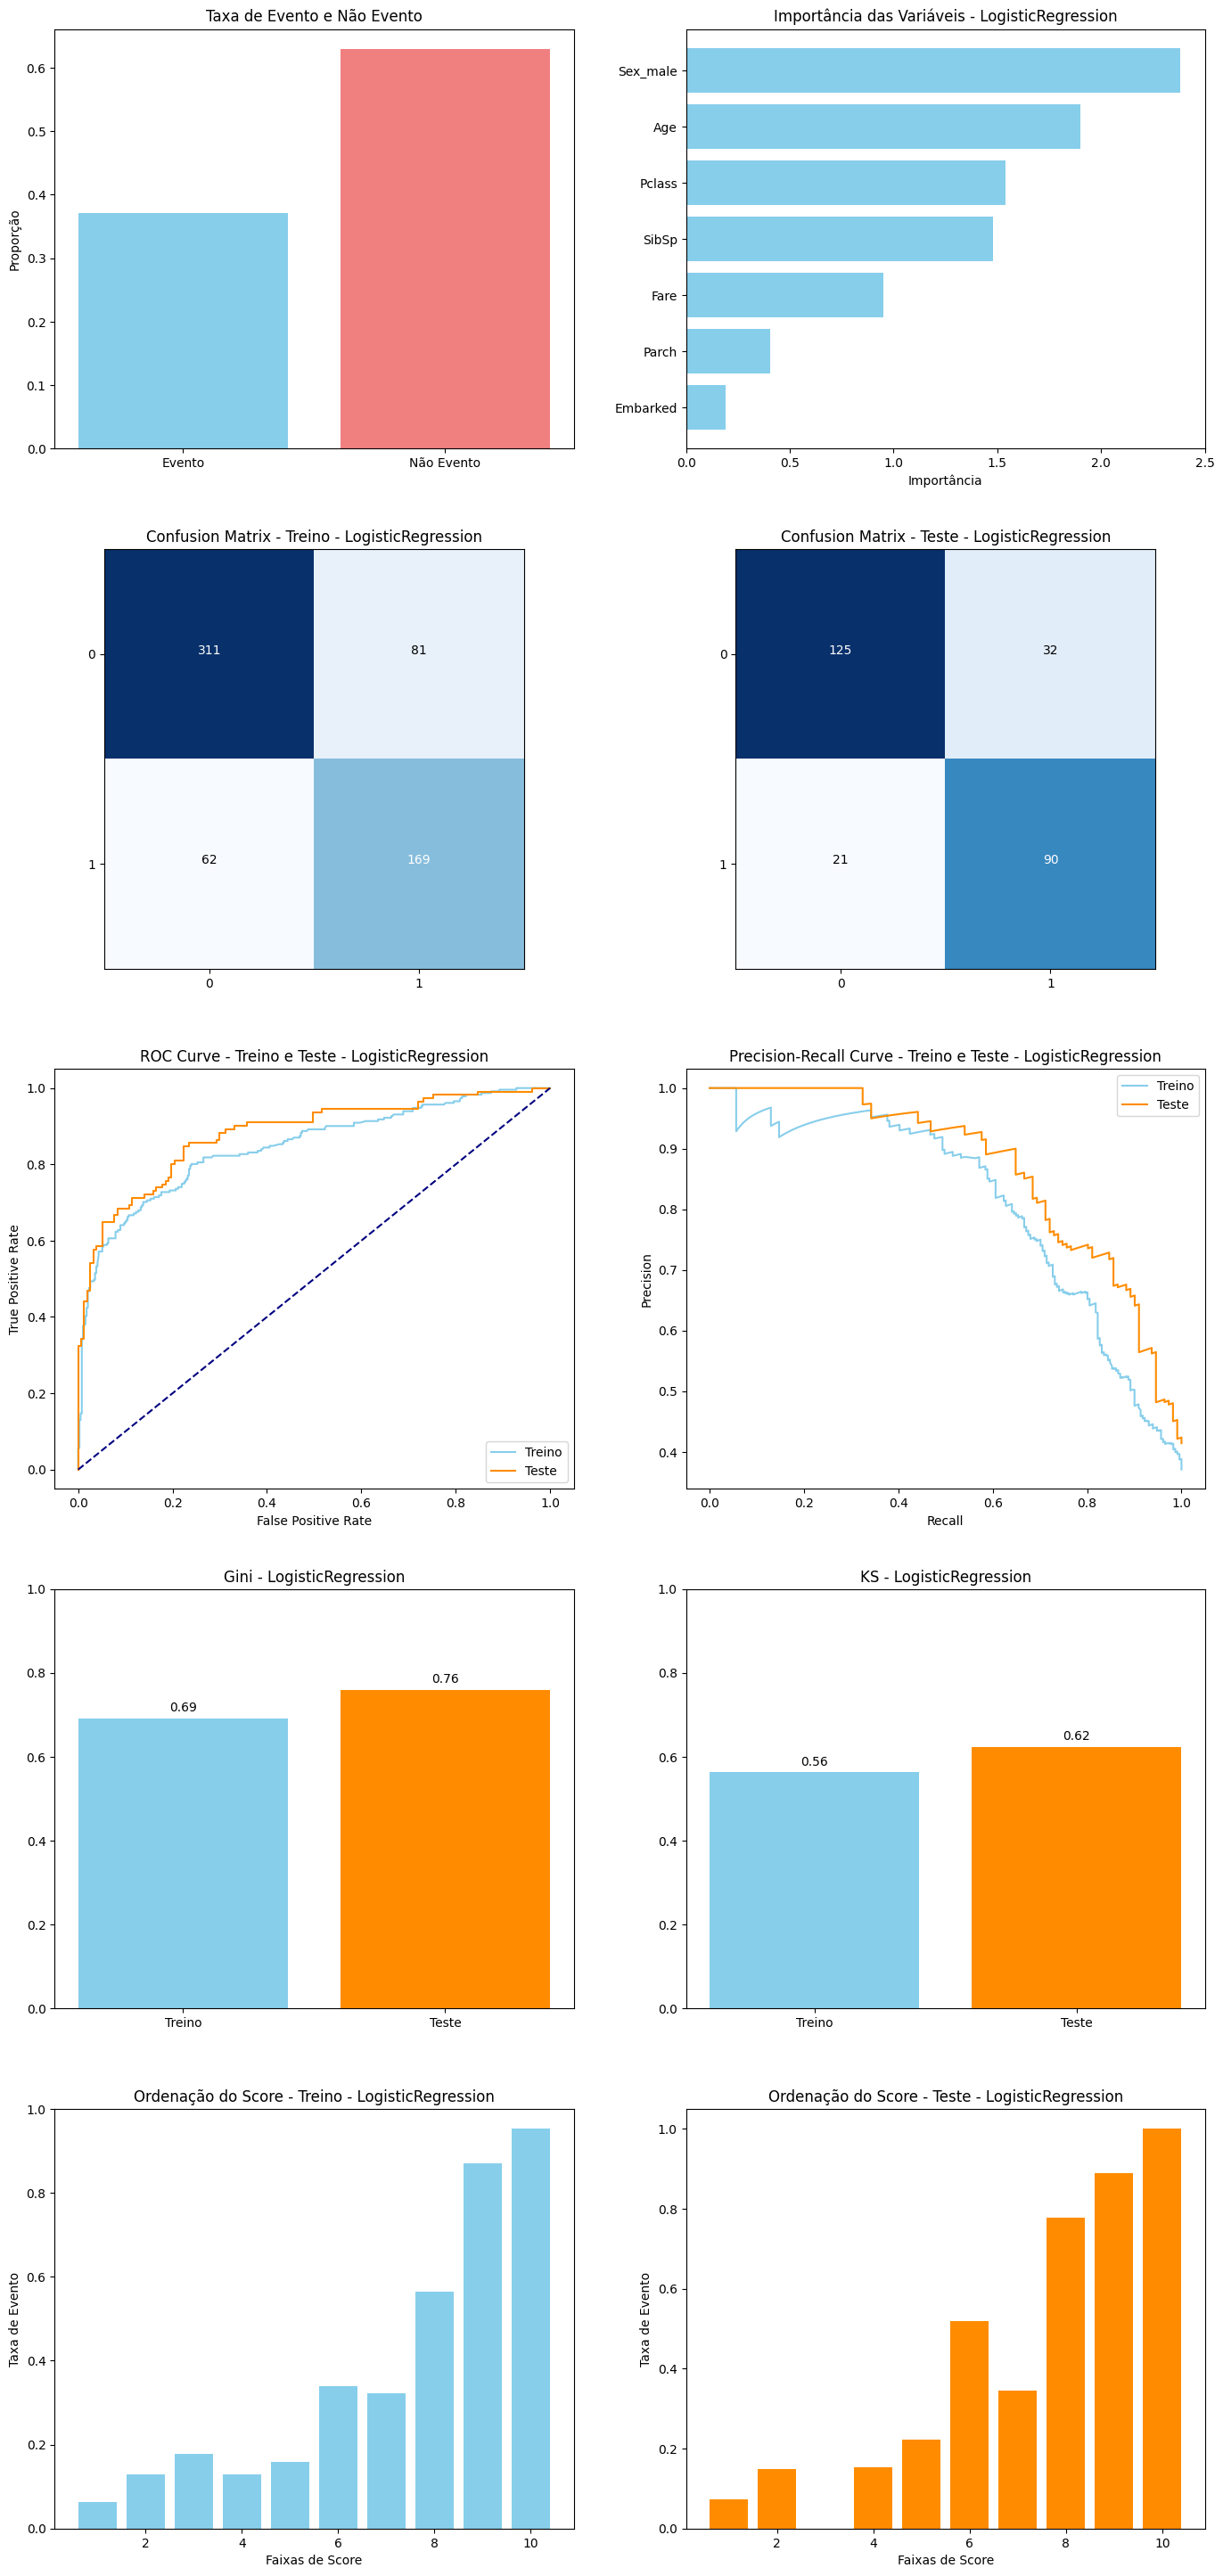

In [51]:
import itertools
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, roc_auc_score
def calcular_ks_statistic(y_true, y_score):
    df = pd.DataFrame({'score': y_score, 'target': y_true})
    df = df.sort_values(by='score', ascending=False)
    total_events = df.target.sum()
    total_non_events = len(df) - total_events
    df['cum_events'] = df.target.cumsum()
    df['cum_non_events'] = (df.target == 0).cumsum()
    df['cum_events_percent'] = df.cum_events / total_events
    df['cum_non_events_percent'] = df.cum_non_events / total_non_events
    ks_statistic = np.abs(df.cum_events_percent - df.cum_non_events_percent).max()
    return ks_statistic

def avaliar_modelo(X_train, y_train, X_test, y_test, modelo, nm_modelo):

    feature_names = list(X_train.columns)
    # Criação da figura e dos eixos
    fig, axs = plt.subplots(5, 2, figsize=(15, 30))  # Ajustado para incluir novos gráficos
    plt.tight_layout(pad=6.0)

    # Cor azul claro
    cor = 'skyblue'

    # Taxa de Evento e Não Evento
    event_rate = np.mean(y_train)
    non_event_rate = 1 - event_rate
    axs[0, 0].bar(['Evento', 'Não Evento'], [event_rate, non_event_rate], color=[cor, 'lightcoral'])
    axs[0, 0].set_title('Taxa de Evento e Não Evento')
    axs[0, 0].set_ylabel('Proporção')

    # Importância dos Atributos
    importancias = None
    if hasattr(modelo, 'coef_'):
        importancias = np.abs(modelo.coef_[0])
    elif hasattr(modelo, 'feature_importances_'):
        importancias = modelo.feature_importances_

    if importancias is not None:
        importancias_df = pd.DataFrame({'feature': feature_names, 'importance': importancias})
        importancias_df = importancias_df.sort_values(by='importance', ascending=True)

        axs[0, 1].barh(importancias_df['feature'], importancias_df['importance'], color=cor)
        axs[0, 1].set_title('Importância das Variáveis - ' + nm_modelo)
        axs[0, 1].set_xlabel('Importância')

    else:
        axs[0, 1].axis('off')  # Desativa o subplot se não houver importâncias para mostrar

    # Confusion Matrix - Treino
    y_pred_train = modelo.predict(X_train)
    cm_train = confusion_matrix(y_train, y_pred_train)
    axs[1, 0].imshow(cm_train, interpolation='nearest', cmap=plt.cm.Blues)
    axs[1, 0].set_title('Confusion Matrix - Treino - ' + nm_modelo)
    axs[1, 0].set_xticks([0, 1])
    axs[1, 0].set_yticks([0, 1])
    axs[1, 0].set_xticklabels(['0', '1'])
    axs[1, 0].set_yticklabels(['0', '1'])
    thresh = cm_train.max() / 2.
    for i, j in itertools.product(range(cm_train.shape[0]), range(cm_train.shape[1])):
        axs[1, 0].text(j, i, format(cm_train[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm_train[i, j] > thresh else "black")

    # Confusion Matrix - Teste
    y_pred_test = modelo.predict(X_test)
    cm_test = confusion_matrix(y_test, y_pred_test)
    axs[1, 1].imshow(cm_test, interpolation='nearest', cmap=plt.cm.Blues)
    axs[1, 1].set_title('Confusion Matrix - Teste - ' + nm_modelo)
    axs[1, 1].set_xticks([0, 1])
    axs[1, 1].set_yticks([0, 1])
    axs[1, 1].set_xticklabels(['0', '1'])
    axs[1, 1].set_yticklabels(['0', '1'])
    thresh = cm_test.max() / 2.
    for i, j in itertools.product(range(cm_test.shape[0]), range(cm_test.shape[1])):
        axs[1, 1].text(j, i, format(cm_test[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm_test[i, j] > thresh else "black")

    # ROC Curve - Treino e Teste
    y_score_train = modelo.predict_proba(X_train)[:, 1]
    fpr_train, tpr_train, _ = roc_curve(y_train, y_score_train)
    axs[2, 0].plot(fpr_train, tpr_train, color=cor, label='Treino')

    y_score_test = modelo.predict_proba(X_test)[:, 1]
    fpr_test, tpr_test, _ = roc_curve(y_test, y_score_test)
    axs[2, 0].plot(fpr_test, tpr_test, color='darkorange', label='Teste')

    axs[2, 0].plot([0, 1], [0, 1], color='navy', linestyle='--')
    axs[2, 0].set_title('ROC Curve - Treino e Teste - ' + nm_modelo)
    axs[2, 0].set_xlabel('False Positive Rate')
    axs[2, 0].set_ylabel('True Positive Rate')
    axs[2, 0].legend(loc="lower right")

    # Precision-Recall Curve - Treino e Teste
    precision_train, recall_train, _ = precision_recall_curve(y_train, y_score_train)
    axs[2, 1].plot(recall_train, precision_train, color=cor, label='Treino')

    precision_test, recall_test, _ = precision_recall_curve(y_test, y_score_test)
    axs[2, 1].plot(recall_test, precision_test, color='darkorange', label='Teste')

    axs[2, 1].set_title('Precision-Recall Curve - Treino e Teste - ' + nm_modelo)
    axs[2, 1].set_xlabel('Recall')
    axs[2, 1].set_ylabel('Precision')
    axs[2, 1].legend(loc="upper right")

    # Gini - Treino e Teste
    auc_train = roc_auc_score(y_train, y_score_train)
    gini_train = 2 * auc_train - 1
    auc_test = roc_auc_score(y_test, y_score_test)
    gini_test = 2 * auc_test - 1
    axs[3, 0].bar(['Treino', 'Teste'], [gini_train, gini_test], color=[cor, 'darkorange'])
    axs[3, 0].set_title('Gini - ' + nm_modelo)
    axs[3, 0].set_ylim(0, 1)
    axs[3, 0].text('Treino', gini_train + 0.01, f'{gini_train:.2f}', ha='center', va='bottom')
    axs[3, 0].text('Teste', gini_test + 0.01, f'{gini_test:.2f}', ha='center', va='bottom')

    # KS - Treino e Teste
    ks_train = calcular_ks_statistic(y_train, y_score_train)
    ks_test = calcular_ks_statistic(y_test, y_score_test)
    axs[3, 1].bar(['Treino', 'Teste'], [ks_train, ks_test], color=[cor, 'darkorange'])
    axs[3, 1].set_title('KS - ' + nm_modelo)
    axs[3, 1].set_ylim(0, 1)
    axs[3, 1].text('Treino', ks_train + 0.01, f'{ks_train:.2f}', ha='center', va='bottom')
    axs[3, 1].text('Teste', ks_test + 0.01, f'{ks_test:.2f}', ha='center', va='bottom')


    # Decile Analysis - Teste
    scores = modelo.predict_proba(X_test)[:, 1]
    noise = np.random.uniform(0, 0.0001, size=scores.shape)  # Adiciona um pequeno ruído
    scores += noise
    deciles = pd.qcut(scores, q=10, duplicates='drop')
    decile_analysis = y_test.groupby(deciles).mean()
    axs[4, 1].bar(range(1, len(decile_analysis) + 1), decile_analysis, color='darkorange')
    axs[4, 1].set_title('Ordenação do Score - Teste - ' + nm_modelo)
    axs[4, 1].set_xlabel('Faixas de Score')
    axs[4, 1].set_ylabel('Taxa de Evento')

    # Decile Analysis - Treino
    scores_train = modelo.predict_proba(X_train)[:, 1]
    noise = np.random.uniform(0, 0.0001, size=scores_train.shape)  # Adiciona um pequeno ruído
    scores_train += noise
    deciles_train = pd.qcut(scores_train, q=10, duplicates='drop')
    decile_analysis_train = y_train.groupby(deciles_train).mean()
    axs[4, 0].bar(range(1, len(decile_analysis_train) + 1), decile_analysis_train, color=cor)
    axs[4, 0].set_title('Ordenação do Score - Treino - ' + nm_modelo)
    axs[4, 0].set_xlabel('Faixas de Score')
    axs[4, 0].set_ylabel('Taxa de Evento')

    # Mostrar os gráficos
    plt.show()
avaliar_modelo(X_train, y_train, X_test, y_test, modelo_final,nm_modelo='LogisticRegression')